# Анализ лояльности пользователей Яндекс Афиши

Команда маркетинга хочет лучше понимать поведение пользователей. Для этого они просят вас провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит:


- Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Выгрузка данных при помощи SQL

Запустим команду для установки SQLAlchemy и модуля psycopg2:

In [1]:
!pip install sqlalchemy
!pip install psycopg2

  Using cached psycopg2-2.9.11.tar.gz (379 kB)
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-s1yoy1ef/psycopg2_8d090adc4ba4453599564407b0ba0e9d/setup.py'"'"'; __file__='"'"'/tmp/pip-install-s1yoy1ef/psycopg2_8d090adc4ba4453599564407b0ba0e9d/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-eqcbtyye
         cwd: /tmp/pip-install-s1yoy1ef/psycopg2_8d090adc4ba4453599564407b0ba0e9d/
    Complete output (23 lines):
    running egg_info
    creating /tmp/pip-pip-egg-info-eqcbtyye/psycopg2.egg-info
    writing /tmp/pip-pip-egg-info-eqcbtyye/psycopg2.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-

Также импортируем требуемые библиотеки и функцию create_engine() из библиотеки SQLAlchemy для подключения к базе данных и выполнения SQL-запроса:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip install phik
import phik
from phik import report

from sqlalchemy import create_engine

Для подключения к базе данных Практикума используем следующие данные:

In [3]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', #хост
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             } 

Далее передаем функции create_engine() строку для соединения с базой данных:

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

К базе подключились, теперь можно извлекать результаты SQL-запроса.

In [5]:
query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

df = pd.read_sql_query(query, con=engine)
display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область


Выгрузка из базы данных SQL содержит 290611 строк и следующие столбцы:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа;
- `order_ts` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.


---

**Задача 1.2:** Изучение общей информации о выгруженных данных. 

Для вывода общей информации воспользуемся методом `describe()`:

In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

None

По результатам анализа видим, что в данных нет пропусков - кроме тех, которые были созданы нами же в столбце days_since_prev. Впоследствии эти пропуски стоит оставить как есть, ведь они и так дают требуемую информацию.
С типами данных также никаких операций проделывать не надо - они корректны и понижение разрядности в них не требуется.

---

###  2. Предобработка данных

Первым делом проверим данные на явные дубликаты. Таковыми будут являться заказы, совершенные одним пользователем в одно и то же время. Поэтому проверим наличие дубликатов по столбцам user_id и order_ts:

Как было сказано выше, данные в выгруженном датафрейме достаточно структурированны:
- Пропуски присутствуют только в созданном нами столбце, в котором пропуски допустимы и являются индикатором;
- Преобразование данных в столбцах не требуется, как и понижение разряда;

Перед дальнейшими операциями с датафреймом зафиксируем количество его строк:

In [7]:
df_len_before = len(df)
display(df_len_before)

290611

Первым делом проверим данные на явные дубликаты. Таковыми будут являться заказыЮ совершенные одним ользователем в одно и то же время. Поэтому проверим наличие дубликатов по столбцам user_id и order_ts:

In [8]:
obv_duplicates = df[['user_id', 'order_ts']].duplicated().sum()

display(obv_duplicates)
display(round(obv_duplicates / df_len_before * 100, 2))

170

0.06

В данных выявлено 170 явных дубликатов, которые требуется удалить:

In [9]:
df = df.drop_duplicates(subset=['user_id', 'order_ts'])

Далее проверим наличие в данных неявных дубликатов. Они могут встретиться в текстовых столбцах event_type_main, service_name, city_name и region_name. Проверим каждый из них на уникальные значения:

In [10]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [11]:
df = df.sort_values(by = 'service_name')
df['service_name'].unique()

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

В данном случае потенциальными дубликатами могут являться заказы, сделанные через операторов Городской дом культуры и Дом культуры. Проверим данные, в которых встречаются эти значения в столбце service_name:

In [12]:
dupl = df[df['service_name'].isin(['Городской дом культуры', 'Дом культуры'])].sort_values(by = ['user_id', 'order_ts'])
display(dupl.head(20))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
45,002ec276eee9b0b,mobile,1635543,2024-07-21,2024-07-21 13:14:01,rub,1308.74,3,0.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
44,002ec276eee9b0b,mobile,1635572,2024-07-21,2024-07-21 13:17:50,rub,1744.99,4,11.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
154,009201290d7316b,mobile,5757632,2024-09-19,2024-09-19 10:36:41,rub,461.19,2,9.0,534026,5ac0c8be-1d29-48a2-865a-6658688f8e37,концерты,Городской дом культуры,Озёрск,Североярская область
271,00ef34b0b483ba6,mobile,6281227,2024-10-30,2024-10-30 20:57:13,rub,124.98,1,0.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
269,00ef34b0b483ba6,mobile,6281314,2024-10-30,2024-10-30 21:01:46,rub,249.97,2,2.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
270,00ef34b0b483ba6,mobile,6281169,2024-10-30,2024-10-30 21:03:02,rub,124.98,1,0.0,11361,64a1d1c9-c17a-4bb8-b8e9-8c91e8d25805,театр,Городской дом культуры,Озёрск,Североярская область
541,01370a0e9c1a7d5,mobile,5117747,2024-09-18,2024-09-18 15:14:04,rub,333.64,2,2.0,10675,7596bae4-3432-4968-b9a3-dad4cb24fc07,театр,Городской дом культуры,Озёрск,Североярская область
592,01370a0e9c1a7d5,desktop,2078170,2024-10-17,2024-10-17 18:12:17,rub,258.10,5,0.0,201834,457ed08d-a916-4741-931d-45a7b44531bd,театр,Городской дом культуры,Озёрск,Североярская область
664,0159dcb26a3c6f3,mobile,6842754,2024-07-27,2024-07-27 21:30:57,rub,1308.74,3,9.0,460567,2802fc66-4268-4529-8b4d-35a6a77ac375,концерты,Дом культуры,Глиногорск,Каменевский регион
805,019fa401ddb00aa,mobile,7991009,2024-06-09,2024-06-09 12:18:22,rub,613.95,3,1.0,11211,32aaab11-12ea-403b-b2e4-85ff7f280982,театр,Городской дом культуры,Озёрск,Североярская область


В строках дубликаты не обнаружены - значит, это все-таки разные операторы.
Продолжим наше исследование текстовых столбцов:

In [13]:
df = df.sort_values(by = 'city_name')
df['city_name'].unique()

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

In [14]:
df = df.sort_values(by = 'region_name')
df['region_name'].unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

В данных присутствует некоторое количество похожих наименований округов и областей, но это не говорит о том, что они являются дубликатами. Поэтому неявных дубликатов по данному столбцу нет.

Получается, что по итогам проверки на явные и неявные дубликаты было выявлено и удалено всего 170 строк с ними, что уменьшило датафрейм всего на 0.06% от изначального размера датафрейма.

**Задача 2.1:** Перевод выручки из тенге в рубли (если требуется)

Для удобства дальнейшей работы не лишним будет привести денежные единицы к одной валюте - например, к рублю. Сделать это можно при помощи датафрейма final_tickets_tenge_df.csv. Загрузим его и изучим:

In [15]:
df_money = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df_money

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


В данном датафрейме приведены курсы тенге к рублю на каждый день 2024 года с 10 января по 31 декабря (всего 357 строк).

Сразу же проверим тип данных в новом датафрейме:

In [16]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


По результатам видим, что потенциальный столбец с датой, по которому в дальнейшем мы будем объединять датафреймы, представлен в некорректном формате object, который требуется перевести в datetime. Сделаем это:

In [17]:
df_money['data'] = pd.to_datetime(df_money['data'])
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


После смены типа данных этот датафрейм мы мождем присоединить к нашему изначальному при помощи левого присоединения. Также после объединения стоит вернуть прежнюю сортировку датафрейма - по возрастанию значений в столбцах user_id и order_dt:

In [18]:
new_df = pd.merge(df, df_money, left_on = 'order_dt', right_on = 'data')
new_df = new_df.sort_values(by = ['user_id', 'order_dt']).reset_index(drop=True)
new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,100,19.6648,kzt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290436,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,100,19.9266,kzt
290437,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,100,19.9266,kzt
290438,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион,2024-10-30,100,19.9516,kzt
290439,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область,2024-09-24,100,19.3967,kzt


Теперь на основании этого датафрейма мы можем произвести пересчет суммы выручки с тенге в рубли. Для этого создадим цикл, перебирающий все строки датафрейма и возвращающий в пустой список revenue_rub либо исходные зачения в рублях, либо пересчитанные:

In [19]:
revenue_rub = []

# Создадим список, перебирающий все строки датафрейма:
for i in range(len(new_df)):
    # Обращаемся к значениям в конкретной строке
    if new_df.loc[i, 'currency_code'] == 'rub':
        revenue_rub.append(new_df.loc[i, 'revenue'])
    elif new_df.loc[i, 'currency_code'] == 'kzt':
        revenue_rub.append(round(new_df.loc[i, 'revenue'] * new_df.loc[i, 'curs'] / new_df.loc[i, 'nominal'], 2))

display(revenue_rub)

[1521.94,
 289.45,
 1258.57,
 8.49,
 1390.41,
 902.74,
 917.83,
 47.78,
 74.84,
 1421.91,
 1421.91,
 710.95,
 710.95,
 1421.91,
 1421.91,
 1066.43,
 1421.91,
 1421.91,
 1066.43,
 1066.43,
 1066.43,
 1066.43,
 470.59,
 235.3,
 0.0,
 588.12,
 479.54,
 306.58,
 193.75,
 193.42,
 193.42,
 424.36,
 129.4,
 382.06,
 1018.82,
 142.79,
 757.02,
 841.26,
 271.07,
 203.3,
 236.75,
 352.08,
 1503.25,
 1305.04,
 1308.74,
 1744.99,
 1011.28,
 1011.28,
 1011.28,
 911.89,
 1215.85,
 196.98,
 96.79,
 127.88,
 399.65,
 599.47,
 999.12,
 799.3,
 599.47,
 599.47,
 1470.44,
 153.47,
 103.53,
 484.35,
 1712.47,
 0.0,
 0.0,
 0.0,
 0.0,
 715.65,
 98.5,
 1241.23,
 1055.64,
 2352.66,
 232.2,
 1057.64,
 1057.64,
 1414.37,
 2121.55,
 1414.37,
 2828.74,
 39.78,
 1043.46,
 6.71,
 356.01,
 47.59,
 782.75,
 391.37,
 587.06,
 65.73,
 723.84,
 1653.84,
 239.53,
 159.68,
 594.55,
 47.56,
 61.15,
 103.2,
 618.41,
 412.27,
 824.54,
 543.01,
 1018.82,
 719.8,
 719.8,
 1045.71,
 380.07,
 251.08,
 534.44,
 1450.38,
 725.19,

Данный список мы можем присоединить в качестве столбца к нашему исходному датафрейму:

In [20]:
# Добавляем результат в датафрейм
df['revenue_rub'] = revenue_rub

display(df)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
220541,b7c563717f1906e,mobile,5219189,2024-08-30,2024-08-30 21:28:32,rub,797.64,2,0.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,1521.94
160553,8187dac4be757a0,desktop,593660,2024-10-02,2024-10-02 19:11:32,rub,459.62,3,0.0,418579,b715360e-fb3b-46ec-bf05-13e6e4361593,другое,Билеты без проблем,Акбастау,Белоярская область,289.45
251890,dba80368a42e538,mobile,3258876,2024-08-04,2024-08-04 11:02:57,rub,1196.46,3,22.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,1258.57
220548,b7c563717f1906e,mobile,5219160,2024-08-30,2024-08-30 21:25:55,rub,797.64,2,0.0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Акбастау,Белоярская область,8.49
165446,86bae757b57e922,mobile,1007664,2024-09-29,2024-09-29 16:31:10,rub,173.81,3,NaN,541929,abe7f74a-5653-4add-ba02-8f377d74bdc1,концерты,Лови билет!,Акбастау,Белоярская область,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162757,831ee0f3c55c208,mobile,4392486,2024-09-06,2024-09-06 15:04:07,rub,56.06,4,5.0,524028,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Солнечелесье,Яснопольский округ,1448.36
4391,02ea4583333f064,mobile,6729712,2024-08-26,2024-08-26 13:46:34,rub,46.19,2,0.0,533411,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Байкуль,Яснопольский округ,965.57
257634,e220d45e5e7c67f,mobile,3147806,2024-08-28,2024-08-28 20:24:12,rub,90.79,3,0.0,533402,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Зеленогорье,Яснопольский округ,178.95
162758,831ee0f3c55c208,mobile,4392399,2024-09-06,2024-09-06 15:35:40,rub,56.06,4,0.0,524028,86d035c8-c40e-4ae4-ac31-6594cee62c25,другое,Билеты без проблем,Солнечелесье,Яснопольский округ,661.53


---

**Задача 2.2:** Анализ данных

Далее произведем работу с численными типами данных. Начнем с очевидного: выручка при продаже не должна быть отрицательной. В связи с этим оценим абсолютное и отнсительное количество строк с отрицательным значением в столбце revenue_rub (если такие будут)

In [21]:
rev_negat_count = len(df[df['revenue_rub'] < 0])
rev_negat_pers = rev_negat_count / len(df) * 100

display(rev_negat_count)
display(rev_negat_pers)

379

0.13049121852631

В данных содержится 379 строка с отрицательными значениями, что составляет менее 0,2% всех данных. Из-за их малого количества и неинформативности их стоит удалить:

In [22]:
df = df[df['revenue_rub'] >= 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290062 entries, 220541 to 124509
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290062 non-null  object        
 1   device_type_canonical  290062 non-null  object        
 2   order_id               290062 non-null  int64         
 3   order_dt               290062 non-null  datetime64[ns]
 4   order_ts               290062 non-null  datetime64[ns]
 5   currency_code          290062 non-null  object        
 6   revenue                290062 non-null  float64       
 7   tickets_count          290062 non-null  int64         
 8   days_since_prev        268168 non-null  float64       
 9   event_id               290062 non-null  int64         
 10  event_name             290062 non-null  object        
 11  event_type_main        290062 non-null  object        
 12  service_name           290062 non-null 


Также проверим этот столбец на наличие выбросов: для этого рассчитаем меры размаха и построим диаграмму размаха по этому столбцу:

In [23]:
df['revenue_rub'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    290062.000000
mean        556.410806
std         875.986360
min           0.000000
25%         114.670000
50%         352.270000
75%         802.250000
95%        1631.094500
99%        2628.420000
max       81174.540000
Name: revenue_rub, dtype: float64

<AxesSubplot:>

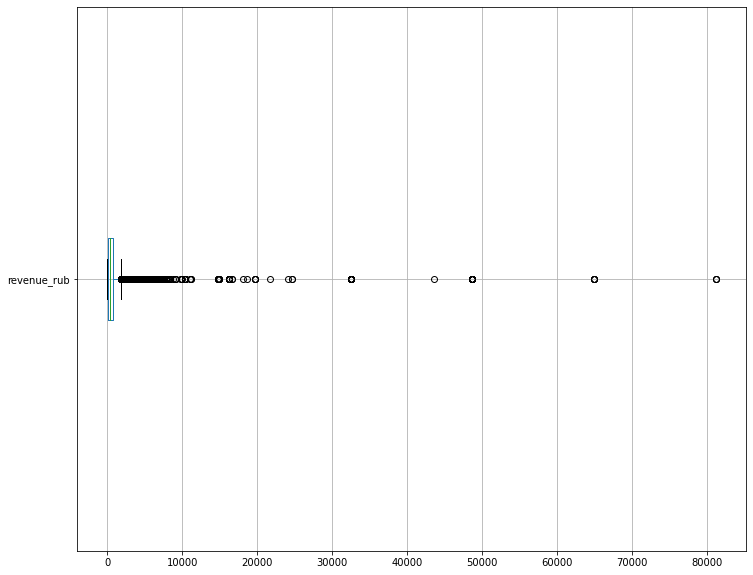

In [24]:
df.boxplot(column='revenue_rub',
           vert=False,
           grid=True,
           figsize=(12, 10))

По графику достаточно наглядно видно, что в данных этого столбца представлено достаточно большое количество выбросов - даже 99й процентиль на порядок ниже максимального значения.
При такой ситуации также стоит оценить количество таких выбросов:

In [25]:
border = df['revenue_rub'].quantile(0.99)
display(len(df[df['revenue_rub'] > border]))
display(len(df[df['revenue_rub'] > border]) / len(df) * 100)

2824

0.9735849576986989

В столбце revenue_rub менее 1% данных (2824 строк) содержат выбросы, поэтому их также можно удалить:

In [26]:
df = df[df['revenue_rub'] <= border]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287238 entries, 220541 to 124509
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287238 non-null  object        
 1   device_type_canonical  287238 non-null  object        
 2   order_id               287238 non-null  int64         
 3   order_dt               287238 non-null  datetime64[ns]
 4   order_ts               287238 non-null  datetime64[ns]
 5   currency_code          287238 non-null  object        
 6   revenue                287238 non-null  float64       
 7   tickets_count          287238 non-null  int64         
 8   days_since_prev        265566 non-null  float64       
 9   event_id               287238 non-null  int64         
 10  event_name             287238 non-null  object        
 11  event_type_main        287238 non-null  object        
 12  service_name           287238 non-null 

Также интерес представляет столбец tickets_count, содержащий количество билетов в заказе. Для него легитимны все те требования, которые предъявлялись к столбцу revenue_rub - неотриуательность значений и невозможность содержания достаточно большого значения.
Проведем с ним аналогичнные операции:

In [27]:
tickets_negat_count = len(df[df['tickets_count'] < 0])
tickets_negat_pers = tickets_negat_count / len(df) * 100

display(tickets_negat_count)
display(tickets_negat_pers)

0

0.0

Отрицательного количества билетов в заказах не обнаружено - отлично!
Теперь проверим распределение значений в столбце:

In [28]:
df['tickets_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    287238.000000
mean          2.754225
std           1.170843
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

<AxesSubplot:>

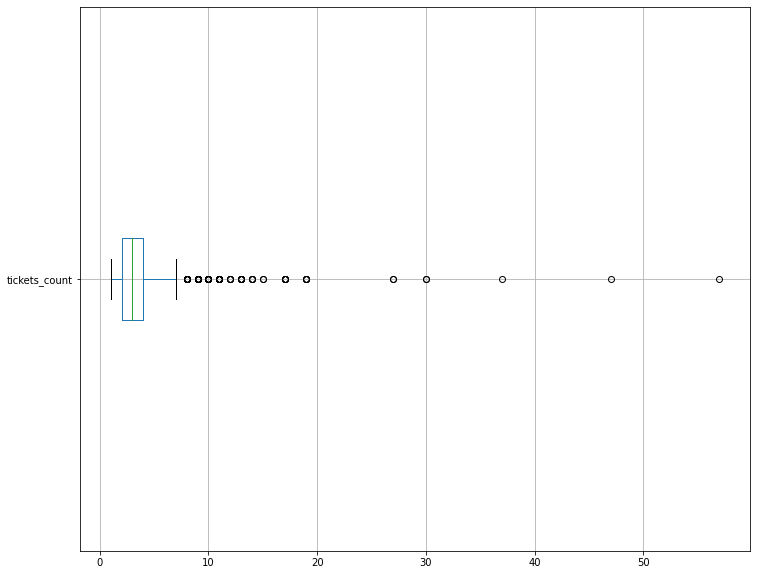

In [29]:
df.boxplot(column='tickets_count',
           vert=False,
           grid=True,
           figsize=(12, 10))

Здесь ситуация не столь плачевна - выбросы присутствуют, и некоторые из них даже достаточно велики (около 13 заказов содержали в себе более 10 билетов), но их не так много и они могут быть абсолютно нормальными - например, несколько классов одной школы (или несколько групп одного детского сада) были записаны на один и тот же спектакль, а все билеты покупал один учитель (воспитатель), которому предварительно были сданы деньги.

Т.к. в процессе предобработки было удалено некоторое количество строк, посчитаем их абсолютное и относительное количество:

In [30]:
df_len_after = len(df)
display(df_len_before - df_len_after)
display((df_len_before - df_len_after) / df_len_before * 100)

3373

1.1606580618077087

Удаление некорретных данных было произведено по 3373 строкам, что составляет 1.2% всех данных в датафрейме, что является незначительным количеством и не должно оказать сильного влияния на последующий исследовательский анализ.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Создание профиля пользователя:

Для построения пользователя создадим следующие столбцы:

- `user_id` - идентификатор пользователя;
- `first_order_ts` - дата и время первого заказа;
- `last_order_ts` - датa и время последнего заказа;
- `first_order_device` - устройство, с которого был сделан первый заказ;
- `first_order_region` - регион, в котором был сделан первый заказ;
- `first_order_service` - название билетного партнёра, к которому обращались при первом заказе;
- `first_order_event` - жанр первого посещённого мероприятия;
- `total_orders` - общее количество заказов;
- `avg_revenue_rub` - средняя выручка с одного заказа в рублях;
- `avg_tickets_count` - среднее количество билетов в заказе;
- `avg_orders_interval` - среднее время между заказами;
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

In [31]:
# Создадим пустой датафрейм для создания профиля клиента:
profile = pd.DataFrame()

# Отсортируем датафрейм по времени совершения заказа:
df = df.sort_values(by = 'order_ts')

# Создаем список уникальных пользователей:
users = df['user_id'].unique()
profile['user_id'] = users
profile = profile.set_index('user_id')

# Определяем дату первого заказа каждого пользователя:
first_order_ts = df.groupby('user_id')['order_ts'].min()
profile['first_order_ts'] = first_order_ts

# Определяем дату последнего заказа каждого пользователя:
last_order_ts = df.groupby('user_id')['order_ts'].max()
profile['last_order_ts'] = last_order_ts

# Определяем для каждого пользователя устройство, с которого он сделал первый заказ:
first_order_device = df.loc[df.groupby('user_id')['order_ts'].idxmin()].set_index('user_id')['device_type_canonical']
profile['first_order_device'] = first_order_device

# Определяем для каждого пользователя регион, из которого он сделал первый заказ:
first_order_region = df.loc[df.groupby('user_id')['order_ts'].idxmin()].set_index('user_id')['region_name']
profile['first_order_region'] = first_order_region

# Определяем для каждого пользователя билетного партнера для первого заказа:
first_order_service = df.loc[df.groupby('user_id')['order_ts'].idxmin()].set_index('user_id')['service_name']
profile['first_order_service'] = first_order_service

# Определяем для каждого пользователя жанр первого посещённого мероприятия:
first_order_event = df.loc[df.groupby('user_id')['order_ts'].idxmin()].set_index('user_id')['event_type_main']
profile['first_order_event'] = first_order_event

# Определяем количество заказов каждого пользователя:
total_orders = df.groupby('user_id')['order_ts'].count()
profile['total_orders'] = total_orders

# Определяем среднюю выручку от заказов каждого пользователя в рублях:
avg_revenue_rub = df.groupby('user_id')['revenue_rub'].mean()
profile['avg_revenue_rub'] = avg_revenue_rub

# Определяем среднее количество билетов в заказах каждого пользователя:
avg_tickets_count = df.groupby('user_id')['tickets_count'].mean()
profile['avg_tickets_count'] = avg_tickets_count

# Определяем среднее время между заказами каждого пользователя:
def calc_avg_time_diff(group):
    if len(group) > 1:
        return group.diff().mean()
    return pd.NaT

avg_orders_interval = df.groupby('user_id')['order_ts'].apply(calc_avg_time_diff)
profile['avg_orders_interval'] = avg_orders_interval

# Создание бинарного столбца по количеству заказов (больше/меньше 2х):
is_two = (profile['total_orders'] >= 2).astype(int)
profile['is_two'] = is_two

# Создание бинарного столбца по количеству заказов (больше/меньше 5ти):
is_five = (profile['total_orders'] >= 5).astype(int)
profile['is_five'] = is_five

profile = profile.reset_index()

profile

,user_id,first_order_ts,last_order_ts,first_order_device,first_order_region,first_order_service,first_order_event,total_orders,avg_revenue_rub,avg_tickets_count,avg_orders_interval,is_two,is_five
0,fd4d47438ebb946,2024-06-01 00:00:42,2024-10-31 23:08:37,mobile,Каменевский регион,Прачечная,театр,1089,505.485225,2.707989,0 days 03:22:27.127757352,1,1
1,57ef0a1905ac488,2024-06-01 00:01:58,2024-09-26 05:29:24,mobile,Лесодальний край,Билеты в руки,театр,4,326.575000,2.500000,39 days 01:49:08.666666666,1,0
2,e73089d7d016cd8,2024-06-01 00:03:34,2024-10-31 22:28:51,mobile,Широковская область,Прачечная,театр,742,537.541563,2.739892,0 days 04:57:12.006747638,1,1
3,18e9aead0a393e7,2024-06-01 00:04:54,2024-10-31 23:49:44,mobile,Каменевский регион,Облачко,концерты,4316,515.855473,2.795644,0 days 00:51:03.334878331,1,1
4,0e6fa925c5f346f,2024-06-01 00:05:17,2024-10-31 23:44:57,mobile,Речиновская область,Весь в билетах,концерты,1496,545.460528,2.737968,0 days 02:27:21.458193979,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21826,f0dac51f739f59f,2024-10-31 23:39:53,2024-10-31 23:39:53,mobile,Солнечнореченская область,Облачко,концерты,1,210.970000,1.000000,NaT,0,0
21827,176b51ad2feb561,2024-10-31 23:40:01,2024-10-31 23:40:01,mobile,Североярская область,Мой билет,концерты,1,210.650000,3.000000,NaT,0,0
21828,988e4859d820cb5,2024-10-31 23:43:28,2024-10-31 23:43:28,mobile,Травяная область,Билеты в руки,театр,1,895.350000,2.000000,NaT,0,0
21829,e994c1637905fe5,2024-10-31 23:43:47,2024-10-31 23:43:47,mobile,Североярская область,Мой билет,концерты,1,177.980000,1.000000,NaT,0,0


**Задача 3.2.** Анализ полученного датафрейма

Полученный датафрейм с профилями пользователей содержит данные о 21831 клиенте сервиса. Однако также стоит проверить, какие данные у нас получились.

Для начала посмотрим оуеним общую информацию о датафрейме:

In [32]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21831 entries, 0 to 21830
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   user_id              21831 non-null  object         
 1   first_order_ts       21831 non-null  datetime64[ns] 
 2   last_order_ts        21831 non-null  datetime64[ns] 
 3   first_order_device   21831 non-null  object         
 4   first_order_region   21831 non-null  object         
 5   first_order_service  21831 non-null  object         
 6   first_order_event    21831 non-null  object         
 7   total_orders         21831 non-null  int64          
 8   avg_revenue_rub      21831 non-null  float64        
 9   avg_tickets_count    21831 non-null  float64        
 10  avg_orders_interval  13478 non-null  timedelta64[ns]
 11  is_two               21831 non-null  int64          
 12  is_five              21831 non-null  int64          
dtypes: datetime64[ns

Сразу стоит отметить, что пропуски в данных содержаться только в столбце avg_orders_interval, который говорит о том, что пользователь сделал только один заказ. Этих пропусков достаточно много, поэтому оценим, какой процент пользоввателей всего единожды посещал сервис:

In [33]:
users_with_one_order = profile['avg_orders_interval'].isna().sum()

display(users_with_one_order)
display(round(users_with_one_order / len(profile) * 100, 2))
display(100 - round(users_with_one_order / len(profile) * 100, 2))

8353

38.26

61.74

Целых 38% пользователей совершили всего один заказ на сервере - достаточно большая текучка. Это также означает, что два и более заказов совершили около 62% пользователей.

Также стоит оценить количество пользователей, которые совершили более 5 заказов в сервисе:

In [34]:
five_orders_users = profile['is_five'].sum()

display(five_orders_users)
display(round(five_orders_users / len(profile) * 100, 2))

6340

29.04

Процент пользователей с более чем 5ю заказами также немал - 29%, что говорит  достаточно большом количестве постоянных клиентов сервиса.

Также немаловажным показателем работы сервиса являеься средняя выручка с заказов. Посчитаем ее - для этого рассчитаем сначала суммарную выручку для каждого пользователя, а потом усредним значения между пользователями:

In [35]:
sum_revenue_per_user = profile['avg_revenue_rub'] * profile['total_orders']
avg_revenue_over = sum_revenue_per_user.mean().round(2)

display(avg_revenue_over)

6826.23

Средняя выручка с заказа для всех пользователей составляет около 6800 рублей, что является достаточно большим показателем (с учетом того, что пользователей и их заказов достаточно много).

Стоит также отметить, что в данных присутствует столбец avg_orders_interval в формате timedelta64, с которым нам придется в дальнейшем работать. Однако такой формат для взаимодействия не особо удобен, поэтому можно перевести данные в нем, например, в дни и представить в виде числа с плавающей точкой (в формате float64):

In [36]:
# Переводим данные интервалов времени в числовые:
profile['avg_orders_interval'] = (profile['avg_orders_interval'].dt.total_seconds() / 3600 / 24).round(4)


Однако вернемся к изучению данных по таблице. Не лишним будет также посмотреть, каого рода данные представлены в столбцах со средним количеством заказов, средним количеством билетов в заказе и среднему количеству дней между заказами. Исследуем эти столбцы по очереди с использованием мер размаха и диаграмм размаха.

Также, в связи с возможностью удаления аномальных выбросов, зафиксируем перед этим количество строк в датафрейме:

In [37]:
len_profile_before = len(profile)

Начнем со столбца total_orders:

In [38]:
profile['total_orders'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    21831.000000
mean        13.157345
std        121.214146
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
95%         31.000000
99%        151.000000
max      10118.000000
Name: total_orders, dtype: float64

<AxesSubplot:>

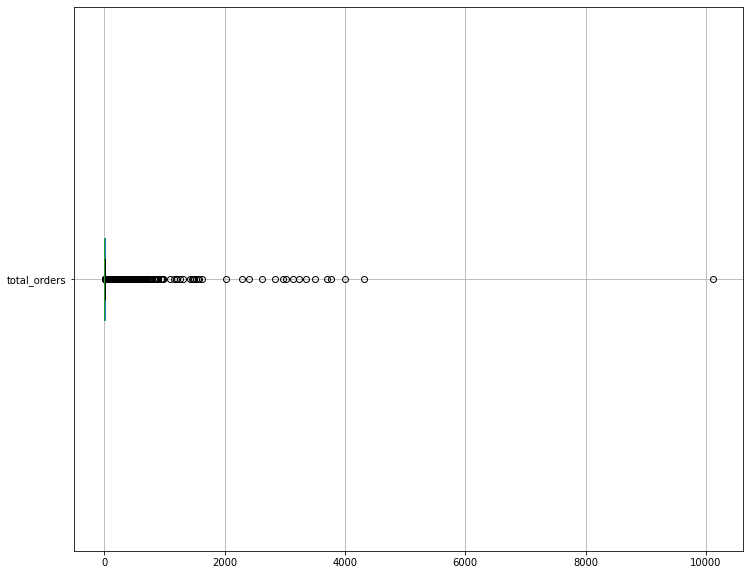

In [39]:
profile.boxplot(column='total_orders',
           vert=False,
           grid=True,
           figsize=(12, 10))

По диаграмме видно, что в данных содержится большое количество выбросов - мало того, что значения 95го и 99го процентилей находятся слишком далеко (31 и 151 заказ соответственно), также существует немалое количество клиентов с количеством заказов свыше 151. Посчитаем их количество:

In [40]:
extra_tickets_count = profile['total_orders'].quantile(0.99)
display(len(profile[profile['total_orders'] > extra_tickets_count]))
display(len(profile[profile['total_orders'] > extra_tickets_count]) / len(profile) * 100)

218

0.9985800009161284

Пользователей, совершивших более 151 заказа за исследуемый период - 218 штук (около 1% всего датафрейма). Если вспомнить, что в датафрейме содержаться данные с июня по октябрь, т.е за 5 месяцев или около 150 дней, стоит отметить, что такие пользователи совершают более одного заказа в день ежедневно! Конечно, в совершении более чем одного заказа в день нет ничего странного - например, вы собрались сходить с друзьями на концерт, один из вас купил билеты на всех, а потом с одним из вас решила пойти девушка, и билеты пришлось докупать. Но чтобы такая ситуация происходила ежедневно - это практически невозможно. Поэтому выбросы по данному показателю свыше 99го процентиля стоит удалить из датафрейма:

In [41]:
profile = profile[profile['total_orders'] <= extra_tickets_count]

Аналогичным образом исследуем столбец avg_tickets_count:

In [42]:
profile['avg_tickets_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    21613.000000
mean         2.755653
std          0.924214
min          1.000000
25%          2.000000
50%          2.767442
75%          3.142857
95%          4.000000
99%          5.000000
max         12.000000
Name: avg_tickets_count, dtype: float64

<AxesSubplot:>

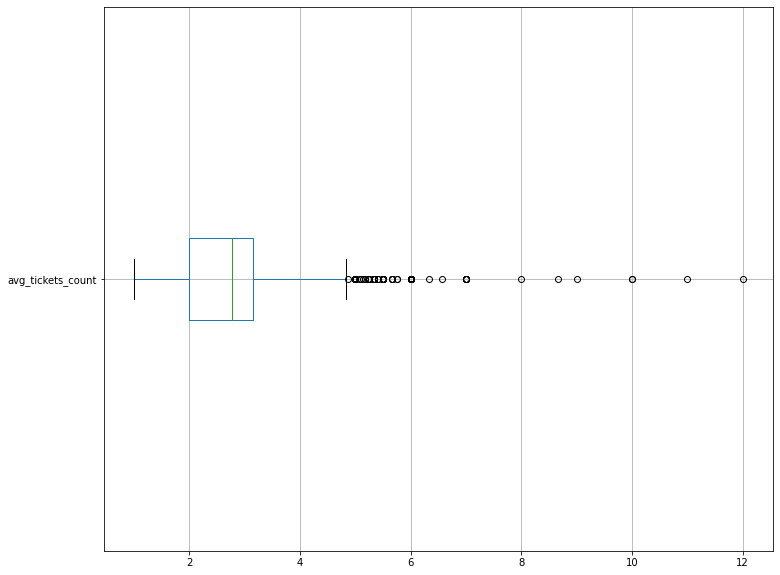

In [43]:
profile.boxplot(column='avg_tickets_count',
           vert=False,
           grid=True,
           figsize=(12, 10))

В данном столбце также присутствуют выбросы выше 99го процентиля, однако они не настолько странные - один пользователь вполне может купить более 5 билетов за раз - например, для похода большой компанией на концерт или классом в театр (в таком случае заказ будет оформлять учитель). Так что выбросы в данном столбце стоит оставить.

Последним шагом исследуем данные в столбце avg_orders_interval:

In [44]:
profile['avg_orders_interval'].describe(percentiles = [0.25, 0.5, 0.75, 0.95, 0.99])

count    13260.000000
mean        16.040388
std         22.274120
min          0.000000
25%          1.325675
50%          8.383950
75%         20.700300
95%         61.456550
99%        112.340044
max        148.227800
Name: avg_orders_interval, dtype: float64

<AxesSubplot:>

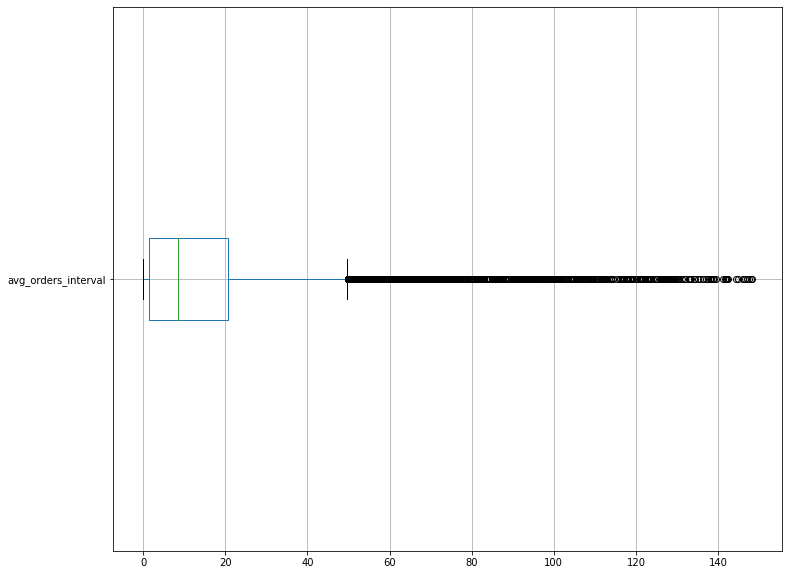

In [45]:
profile.boxplot(column='avg_orders_interval',
          vert=False,
           grid=True,
           figsize=(12, 10))

На основании полученных данных также можно сказать, что выбросы в данном столбце вполне возможны и не являются аномальными - один и тот же клиент вполне может захотеть пойти на мероприятие в начале июня и в конце августа, а перерывы между посещенияи мероприятий одним пользователем вполне могут быть как короткими, так и достаточно длинными. Поэтому выбросы в данном случае также стоит оставить.

По итогам операций с аномальными значениями в данных было удалено всего 218 строк (около 1% всех данных в датафрейме), содержащих аномально большое количество заказов. Данные же, представленныне в столбцах со средним количеством билетов в заказе и среднему количеству дней между заказами также содержат выбросы, однако они не являются аномальными и изменению (удалению) не подлежат.

Также после удаления некоторых строк датафрейма стоит пересчитать характеристики, определенные перед этим - количество пользователей, совершивших менее 2х и более 5ти заказов, а также среднюю выручку за заказ:

In [46]:
users_with_one_order = profile['avg_orders_interval'].isna().sum()

display(users_with_one_order)
display(round(users_with_one_order / len(profile) * 100, 2))
display(100 - round(users_with_one_order / len(profile) * 100, 2))

8353

38.65

61.35

Количество пользователей, совершивших 1 заказ, не изменилось - этого стоило ожидать. А вот их процент относительно всего числа пользователей слегка изменился - с 38,3% до 38,7%.

In [47]:
five_orders_users = profile['is_five'].sum()

display(five_orders_users)
display(round(five_orders_users / len(profile) * 100, 2))

6122

28.33

Количество пользователей с более чем 5ю заказами изменилось, т.к. мы удалили пользователей с аномально большим количеством заказов. Также процентное отношение пользователей с больбшим кол-вом заказов уменьшилось - с 29% до 28,3%

In [48]:
sum_revenue_per_user = profile['avg_revenue_rub'] * profile['total_orders']
avg_revenue_over = sum_revenue_per_user.mean()

display(avg_revenue_over)

3364.669178272337

А вот средняя выручка с заказа уменьшилась более чем вдвое - с 6800 рублей до 3350 рублей. Это тоже вполне ожидаемо, т.к. удаленные клиенты с аномально большим количеством заказов генерировали и аномально большую прибыль, которая после их удаления более не участвовала в анализе.

Также выведем финальную информацию о датафрейме с профилями пользователей после предобработки:

In [49]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 1 to 21830
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              21613 non-null  object        
 1   first_order_ts       21613 non-null  datetime64[ns]
 2   last_order_ts        21613 non-null  datetime64[ns]
 3   first_order_device   21613 non-null  object        
 4   first_order_region   21613 non-null  object        
 5   first_order_service  21613 non-null  object        
 6   first_order_event    21613 non-null  object        
 7   total_orders         21613 non-null  int64         
 8   avg_revenue_rub      21613 non-null  float64       
 9   avg_tickets_count    21613 non-null  float64       
 10  avg_orders_interval  13260 non-null  float64       
 11  is_two               21613 non-null  int64         
 12  is_five              21613 non-null  int64         
dtypes: datetime64[ns](2), float64(3

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и их влияние на вероятность возвращения пользователя.

**Задача 4.1.1.** Изучим распределение пользователей по признакам.

Для начала оценим, какое мероприятие пользователи чаще всего выбирают для первого заказа. Для этого сгруппируем пользователей по столбцу first_order_event и посчитаем количество пользователей в каждой группе:

In [50]:
users_per_event = profile.groupby('first_order_event')['first_order_ts'].count().sort_values(ascending=False)
users_per_event_pers = (users_per_event / len(profile) * 100).round(2)

display(users_per_event)

first_order_event
концерты    9585
другое      5398
театр       4233
стендап     1100
спорт        790
выставки     412
ёлки          95
Name: first_order_ts, dtype: int64

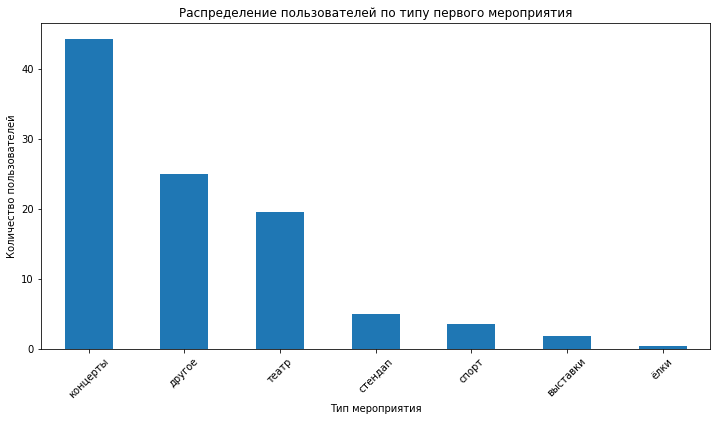

In [51]:
users_per_event_pers.plot(kind='bar',
                    title = 'Распределение пользователей по типу первого мероприятия',
                    xlabel = 'Тип мероприятия',
                    ylabel = 'Количество пользователей',
                    rot =45, 
                    figsize=(12, 6))

plt.show()

Чаще всего в качестве первого мероприятия люди выбирают концерты (более 40% клиентов выбрали именно их), реже - театры (впервые на них пошли примерно 20% человек). Около 6% пользователей выбрали стендап в качестве первого ивента, а менее 6% - спорт, выставки или елки. Стоит также упомянуть категорию "другое", на мероприятия которой пошло около 25% человек - больше, чем на стендап, но сильно меньше, чем на концерт.

Далее оценим распределение пользователей по типам устройств, с котоых они сделали заказ:

In [52]:
users_per_device = profile.groupby('first_order_device')['first_order_ts'].count().sort_values(ascending=False)
users_per_device_pers = (users_per_device / len(profile) * 100).round(2)

display(users_per_device)

first_order_device
mobile     17893
desktop     3720
Name: first_order_ts, dtype: int64

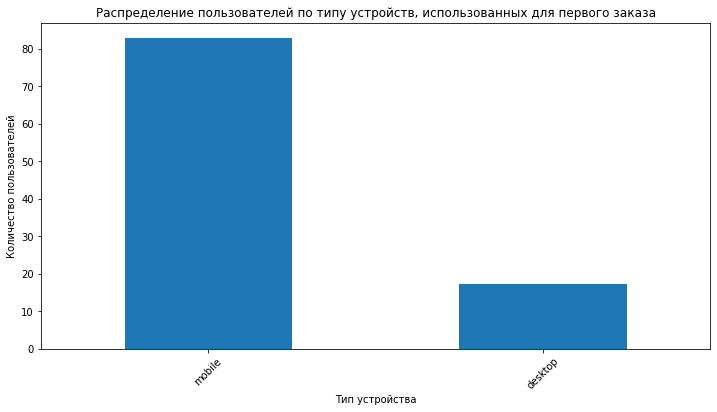

In [53]:
users_per_device_pers.plot(kind='bar',
                    title = 'Распределение пользователей по типу устройств, использованных для первого заказа',
                    xlabel = 'Тип устройства',
                    ylabel = 'Количество пользователей',
                    rot =45, 
                    figsize=(12, 6))

plt.show()

ДЖля первого заказа люди значительно чаще используют мобильные устройства, чем стационарные компьютеры - более 80% пользователей использовали именно смартфон или планшет для первого заказа.

Теперь стоит оценить, а где чаще всего происходят мероприятия, привлекающие людей в сервис:

In [54]:
users_per_region = profile.groupby('first_order_region')['first_order_ts'].count().sort_values(ascending=False)
users_per_region_pers = (users_per_region / len(profile) * 100).round(2)

display(users_per_region)

first_order_region
Каменевский регион          7092
Североярская область        3739
Широковская область         1220
Озернинский край             675
Малиновоярский округ         529
                            ... 
Залесский край                 2
Тихогорская область            2
Верхозёрский край              1
Сосноводолинская область       1
Яснопольский округ             1
Name: first_order_ts, Length: 81, dtype: int64

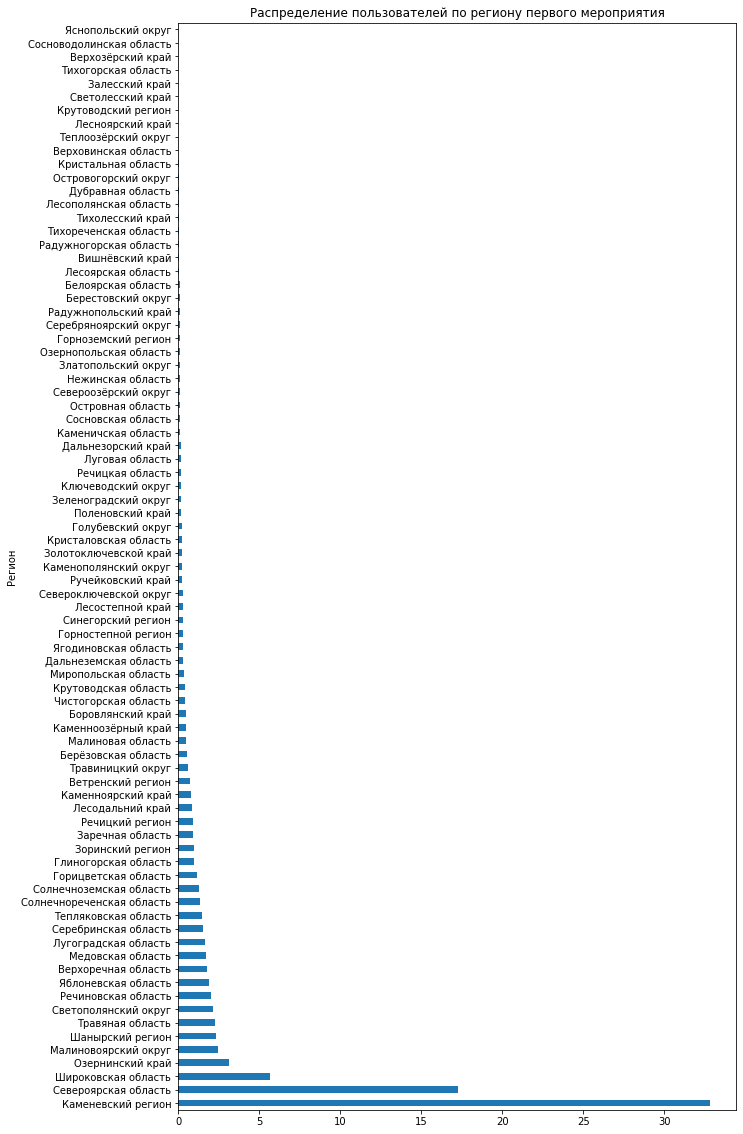

In [55]:
users_per_region_pers.plot(kind='barh',
                    title = 'Распределение пользователей по региону первого мероприятия',
                    xlabel = 'Регион',
                    ylabel = 'Количество пользователей', 
                    figsize=(10, 20))

plt.show()

Лидерами по данной категории выступает Каменевский регион (примерно 33% пользователей), Североярская область (17% пользователей) и Широковская область (6% пользователей). Остальные регионы не пользуются популярностью - их для первого мероприятия выбрали менее 3% клиентов каждый. 

В данных явно выражены топ-3 региона, однако между ними огромные разрывы - разница между первым и вторым местом составляет 2 раза, а между 2м и 3м - почти 3.

Ну и в конце оценим, какие билетные операторы использовались для покупки первого билета чаще всего:

In [56]:
users_per_service = profile.groupby('first_order_service')['first_order_ts'].count().sort_values(ascending=False)
users_per_service_pers = (users_per_service / len(profile) * 100).round(2)

display(users_per_service)

first_order_service
Билеты без проблем        5176
Мой билет                 2988
Лови билет!               2785
Билеты в руки             2541
Облачко                   2160
Весь в билетах            1300
Лучшие билеты             1177
Прачечная                  584
Край билетов               453
Дом культуры               354
Яблоко                     319
Тебе билет!                307
Городской дом культуры     217
Мир касс                   203
За билетом!                202
Show_ticket                164
Быстробилет                162
Выступления.ру              97
Восьмёрка                   87
Быстрый кассир              59
Росбилет                    52
Crazy ticket!               46
Радио ticket                37
Реестр                      31
Телебилет                   27
Цвет и билет                22
Шоу начинается!             20
КарандашРУ                  15
Кино билет                   9
Вперёд!                      7
Билет по телефону            6
Тех билет          

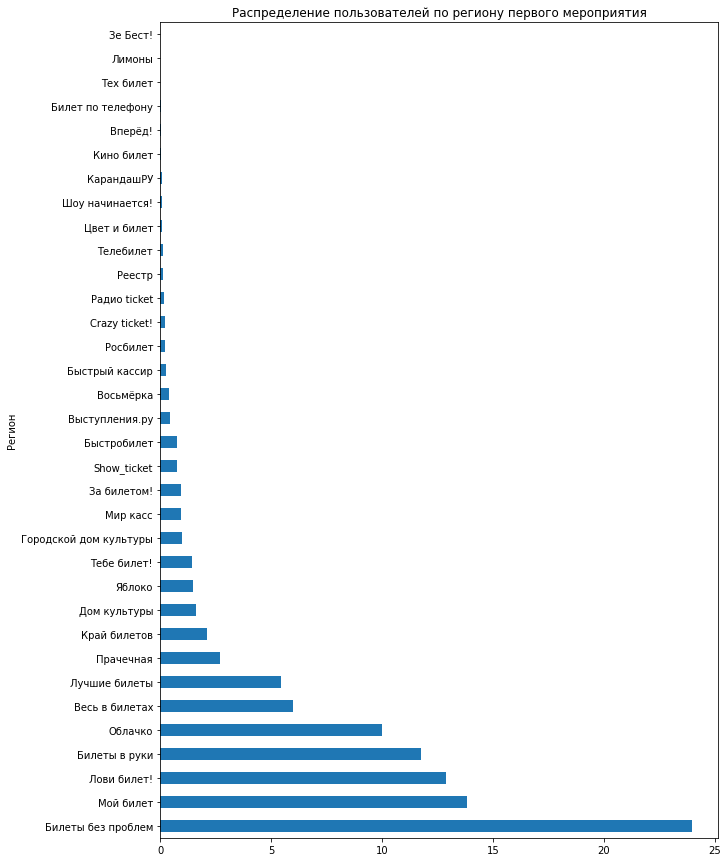

In [57]:
users_per_service_pers.plot(kind='barh',
                           title = 'Распределение пользователей по региону первого мероприятия',
                           xlabel = 'Регион',
                           ylabel = 'Количество пользователей',
                           figsize=(10, 15))

plt.show()

Лидирующее место среди билетных операторов занимает "Билеты без проблем", который использовали для первого заказа 24% пользователей. Примерно 14% использовали "Мой билет", около 12% - "Лови билет!", примерно 11% - "Билеты в руки", а 10% - "Облачко". Около 5% пользователей выбирали для первгого заказа сервисы "Весь в билетах" и "Лучшие билеты". Остальные же сервисы были выбраны менее чем 3% пользователей.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:


Теперь посмотрим, а сохраняться ли результаты предыдущего исследования в прежнем виде, если применить их только к тем клиентам, которые совершили 2 и более заказов. Для этого произведем дополнительную группировку по столбцу is_two и повторим предыдущие исследования:

In [58]:
users_per_event_is2 = (profile.groupby('first_order_event')['is_two'].mean() * 100).sort_values(ascending=False)

display(users_per_event_is2)

first_order_event
театр       63.477439
выставки    62.621359
концерты    61.971831
стендап     60.909091
другое      59.503520
спорт       55.822785
ёлки        54.736842
Name: is_two, dtype: float64

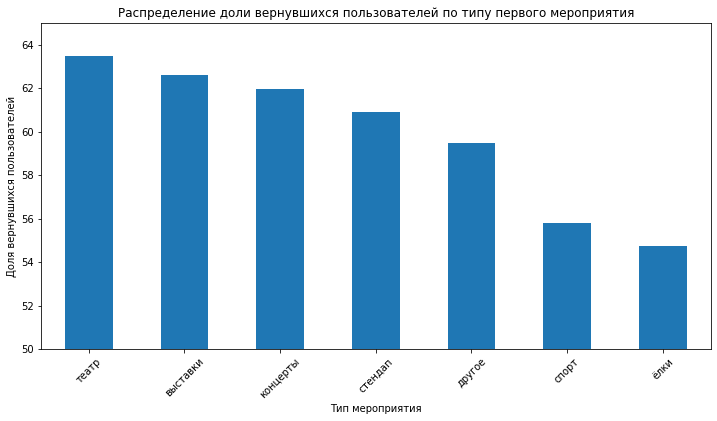

In [59]:
users_per_event_is2.plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по типу первого мероприятия',
                    xlabel = 'Тип мероприятия',
                    ylabel = 'Доля вернувшихся пользователей',
                    rot =45,
                    ylim = [50, 65],
                    figsize=(12, 6))

plt.show()

Согласно полученной диаграмме, среди тех клиентов, которые в качестве первого мероприятия выбрали посещение театра, около 63,5% совершили повторный заказ. Среди тех, кто впервые пошел на выставку, доля вернувшихся составила около 62.6%, среди посетимвших концерт - 62%, а среди посетивших стендап - 61%. Самые низкие показатели по доле вернувшихся у тех клиентов, кто впервые посетил спортивное мероприятие или елку - таких 56% и 55% соответственно.

Далее проверим долю вернувшихся в разрезе типа устройства, с которого был сделан первый заказ:

In [60]:
users_per_device_is2 = (profile.groupby('first_order_device')['is_two'].mean() * 100).sort_values(ascending=False)

display(users_per_device_is2)

first_order_device
desktop    63.736559
mobile     60.856201
Name: is_two, dtype: float64

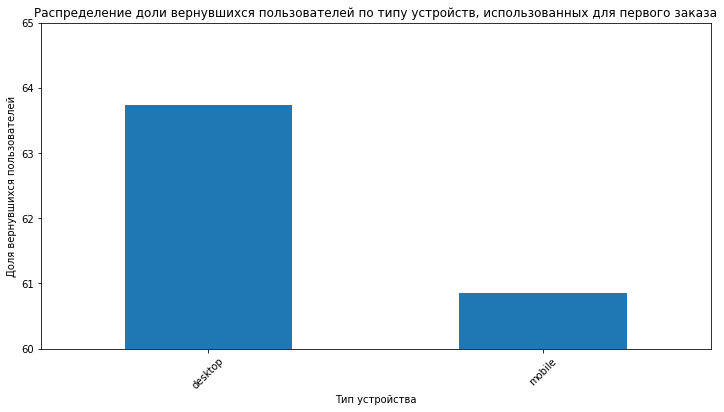

In [61]:
users_per_device_is2.plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по типу устройств, использованных для первого заказа',
                    xlabel = 'Тип устройства',
                    ylabel = 'Доля вернувшихся пользователей',
                    rot =45,
                    ylim = [60, 65],
                    figsize=(12, 6))

plt.show()

Видимо, совершать заказ со стационарного компьютера в сервисе проще - для них доля вернувшихся пользователей на 3% выше, чем для мобильных устройств. В абсолютных величинах это, скорее всего, не так (мы помним, насколько сильно больше количество клиентов, совершивших первый заказ с телефона), однако процентное соотношение таково.

Далее исследуем динамику доли вернувшихся пользователей в разрезе региона мероприятия из первого заказа. Т.к. в предыдущей задаче регионов было слишком много, оставим только 10 самых популярных, и финальную фильтрацию также произведем в этом же порядке:

In [62]:
top_10_regions = profile.groupby('first_order_region')['first_order_ts'].count()
top_10_regions = top_10_regions.sort_values(ascending=False).head(10)

users_per_region_is2 = (profile[profile['first_order_region'].isin(top_10_regions.index)]
                        .groupby('first_order_region')['is_two'].mean() * 100).reindex(top_10_regions.index)

display(users_per_region_is2)

first_order_region
Каменевский регион      62.309645
Североярская область    63.840599
Широковская область     64.508197
Озернинский край        54.814815
Малиновоярский округ    56.521739
Шанырский регион        68.181818
Травяная область        61.680328
Светополянский округ    66.013072
Речиновская область     63.448276
Яблоневская область     59.569378
Name: is_two, dtype: float64

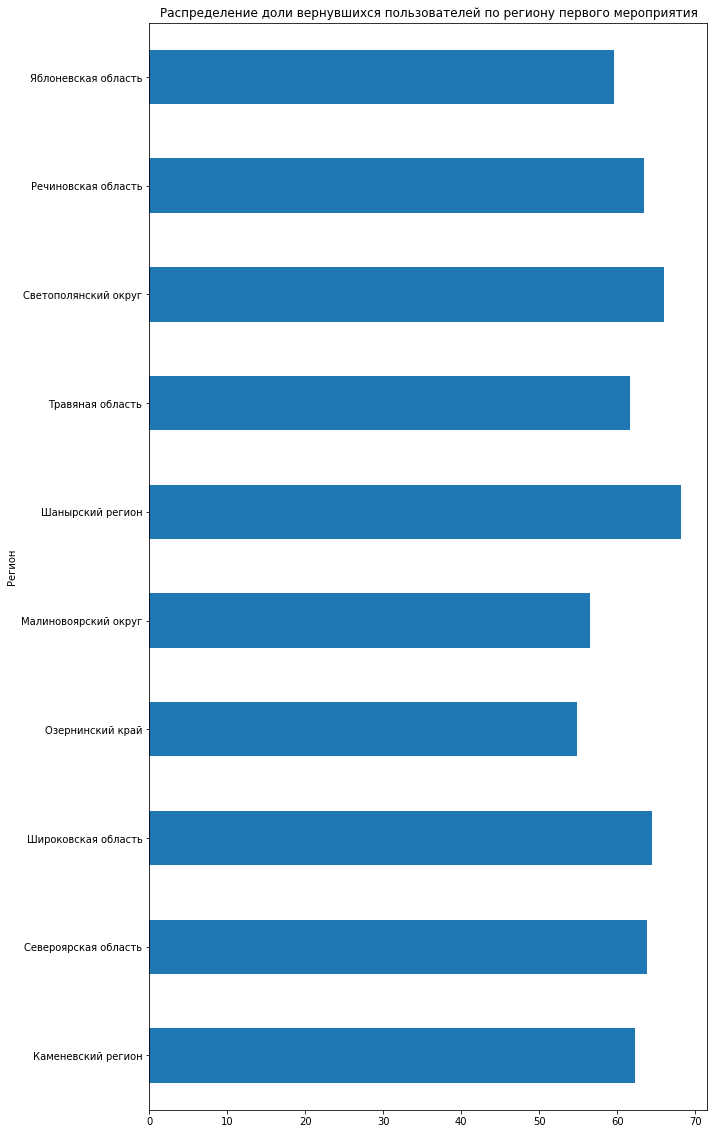

In [63]:
users_per_region_is2.plot(kind='barh',
                    title = 'Распределение доли вернувшихся пользователей по региону первого мероприятия',
                    xlabel = 'Регион',
                    ylabel = 'Доля вернувшихся пользователей',
                    ylim = [58, 63],
                    figsize=(10, 20))

plt.show()

Среди регионов-лидеров по количество первых мероприятий наблюдается обратная пропорциональность относительно доли вернувшихся пользователей - чем меньше заказов в регионе, тем больше доля вернувшихся пользователей. Дальнейшие регионы, в которых примерно похожее ниспадающее количество первых заказов пользователей, распределение также нелинейное. Однако стоит отметить, что для всех регионов в данном списке доля вернувшихся пользователей выше, чем доля тех, кто совершил заказ всего единожды - для всех регионов доля превышает 59%.

В конце исследуем динамику доли вернувшихся пользователей в разрезе сервиса по продаже билетов первого заказа. При этом, также как и в прошлом случае, оставим только топ-10 самых популярных агрегаторов и финальную фильтрацию также произведем в этом же порядке:

In [64]:
top_10_services = profile.groupby('first_order_service')['first_order_ts'].count()
top_10_services = top_10_services.sort_values(ascending=False).head(10)

users_per_service_is2 = (profile[profile['first_order_service'].isin(top_10_services.index)]
                        .groupby('first_order_service')['is_two'].mean() * 100).reindex(top_10_services.index)

display(users_per_service_is2)

first_order_service
Билеты без проблем    60.587326
Мой билет             60.910308
Лови билет!           60.789946
Билеты в руки         62.455726
Облачко               61.620370
Весь в билетах        62.923077
Лучшие билеты         61.002549
Прачечная             62.842466
Край билетов          65.121413
Дом культуры          64.971751
Name: is_two, dtype: float64

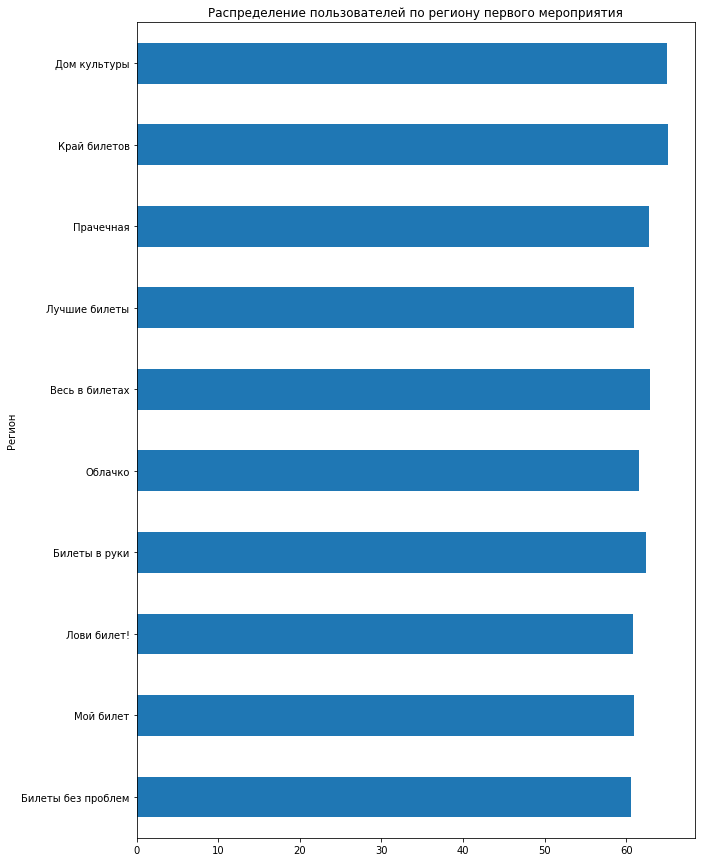

In [65]:
users_per_service_is2.plot(kind='barh',
                           title = 'Распределение пользователей по региону первого мероприятия',
                           xlabel = 'Регион',
                           ylabel = 'Количество пользователей',
                           figsize=(10, 15))

plt.show()

Так же, как и в прошлом исследовании, нельзя однозначно оценить динамику изменения доли вернувшихся пользователей в зависимости от сайта продажи билетов для первого мероприятия пользователя. Хотя можно отметить, что с уменьшением количества пользователей доля тех, кто совершил заказ повторно, увеличивается (динамика нелинейна, но такое можно увидеть).

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Данные гипотезы были проверены выше:
- Гипотеза 1 верна в абслюте, но неверна для конкретного примера: если оценивать долю вернувшихся пользователей, то для относительно небольшого количества пользователей с первым мероприятием типа "выставки" можно отметить достаточно большое количество повторных заказов. Для типов-лидеров по количеству пользователей - "концерт" и "театр" доля вернувшихся пользователей также велика - более 60%. А в категории "спорт", где изначально было небольшое количество пользователей, совершивших 1й заказ, доля вернувшихся пользователей составляет 56%, что все еще больше половины, но меньше, чем у многих других категорий (кроме категории "елки", которая находится на последнем месте по обеим выборкам).

- Гипотеза 2 также не может быть оценена однозначно: по построенным графикам нельзя однозначно сказать, что такая тенденция прослеживается. Линейно-положительной или линейно-отрицательной зависимости в доле вернувшихся пользователей не обнаружено.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Попробуем проследить связь между средней выручкой сервиса с заказа и повторными заказами. Для этого построим гистограмму распределения выручки для вернувшихся и невернувшихся пользователей:

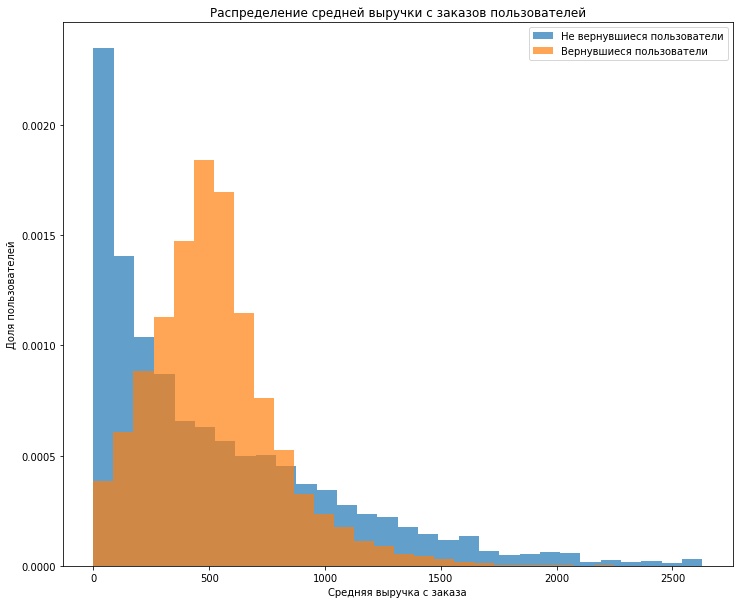

In [66]:
profile.groupby('is_two')['avg_revenue_rub'].plot(kind = 'hist',
                                                          bins = 30,
                                                          legend = True,
                                                          alpha = 0.7,
                                                          density = True,
                                                          figsize = (12, 10))

plt.title('Распределение средней выручки с заказов пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Доля пользователей')
plt.legend(['Не вернувшиеся пользователи', 'Вернувшиеся пользователи'])


Распределение пользователей по средней выручке с заказа в зависимости от количества заказов происходит неравномерно: для тех пользователей, кто совершил всего один заказ в сервисе, заметна наспадающая характеристика - больше всего пользователей принесли сервису выручку всего около 100 рублей, выручку около 200 рублей принесло меньшее количество, около 300 рублей - еще меньшее и т.д. по нисходящей. Для вернувшихся пользователей картина слегка иная - самым популярным значением выручки является около 600 рублей с заказа. При этом данное значение достаточно стремительно растет, но также быстро и снижается. Также стоит отметить, что в области больших значений выручки (более 800 рублей с заказа) количество клиентов, которые воспользовались сервисом единожды, на каждом интервале превышает количество вернувшихся пользователей.

---

**Задача 4.2.2.** Далее проведем аналогичное исследование только для вернувшихся пользователей и разделим их на группы в зависимотсти от значения в столбце is_five:

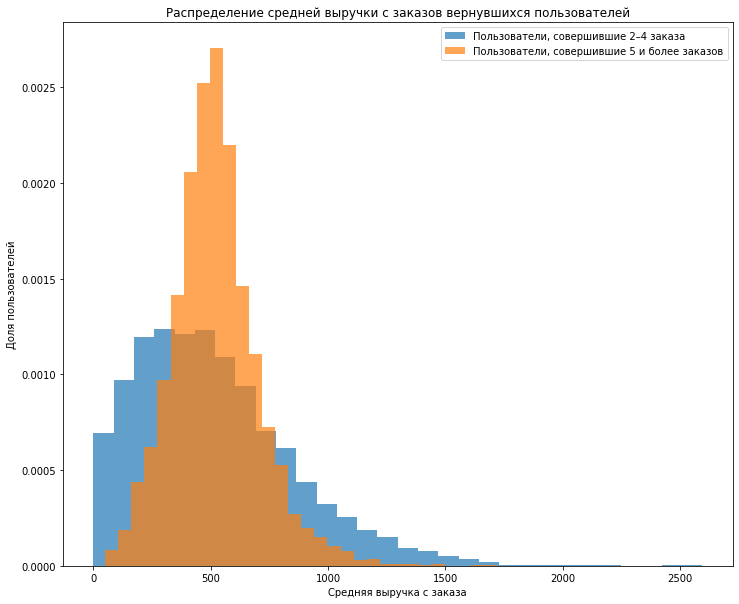

In [67]:
profile[profile['is_two'] == 1].groupby('is_five')['avg_revenue_rub'].plot(kind = 'hist',
                                                                            bins = 30,
                                                                            legend = True,
                                                                            alpha = 0.7,
                                                                            density = True,
                                                                            figsize = (12, 10))

plt.title('Распределение средней выручки с заказов вернувшихся пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Доля пользователей')
plt.legend(['Пользователи, совершившие 2–4 заказа', 'Пользователи, совершившие 5 и более заказов'])

При исследовании пользователей с такой группировкой становится достаточно заметной разница между ними. Если говорить о пользователях, совершивших 2-4 заказа, для них наиболее характерны небольшие значения средней выручки - распределение средней выручки с заказа не имеет ярко выраженного пика и имеет плато в диапазонах средней выручки от 200 до 500 рублей. Дальнейшее снижение доли пользователей идет плавно, без стремительных провалов.

Если же говорить о пользователях с большим количеством заказов, для них явнее видно наиболее часто встречающееся значениесредней выручки - оно составляет 500-600 рублей с клиента. При этом характер изменения для таких пользователей менее размеренный - с увеличением средней выручки доля пользователей для каждого из интервалов сначала стремительно растет, достигая описанного выше пика, а потом также стремительно и снижается. Причем так же, как и в прошлом исследовании, стоит отметить, среди пользователей, совершивших меньшее количество заказов, больше доля тех, кто принес порталу большие выручки, чем среди тех пользователей, кто совершил больше заказов (для значений средней выручки более 800 рублей с пользователя в каждом интервале доля пользователей с 2-4 заказами больше, чем доля пользователей с 5 и более заказами).

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

Для этого разобьем пользователей на группы в зависимости от количества билетов в заказе следующим образом:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов
и определим для каждой категории количество человек в ней и долю вернувшихся пользователей:

In [68]:
# Задаем граничные условия для группировки пользователей:
bins = [1, 2, 3, 5, float('inf')]

profile_copy = profile.copy()

# Создаем столбец с группами
profile_copy['tickets_group'] = pd.cut(profile['avg_tickets_count'], 
                                 bins=bins, 
                                 include_lowest=True)

# Группируем по созданным группам
grouped = profile_copy.groupby('tickets_group').agg(
    user_count=('avg_revenue_rub', 'count'),
    is_two_count=('is_two', 'sum'),
    is_two_mean=('is_two', lambda x: round(x.mean() * 100, 2))).reset_index()

print(grouped)

  tickets_group  user_count  is_two_count  is_two_mean
0  (0.999, 2.0]        6096          2436        39.96
1    (2.0, 3.0]        9838          7284        74.04
2    (3.0, 5.0]        5472          3473        63.47
3    (5.0, inf]         207            67        32.37


По среднему количеству билетов в заказе пользователи распределены следующим образом: наибольшее количество пользователей покупает в среднем от 2х до 3х билетов за раз, меньшее количество - от 1 до 2, примерно такое же, но слегка меньше - от 3 до 5, и единицы покупают более 5 бтлетов в среднем. Распределение же вернувшихся пользователей слегка иное - чаще всего повторный заказ делают пользователи из 2й (у которых в среднем от 2 до 3 билетов в заказе) и 3й (у которых в среднем от 3 до 5 билетов в заказе) групп - среди таких пользовыателей вернулись 74% и 63.5% соответственно. Среди остальных пользователей доля вернувшихся невелика - 40% для пользователей с 1-2 заказами в среднем и 32% для пользователей с более чем 5 заказами.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируем влияние дня недели, в которой была совершена первая покупка, на поведение пользователей. Для этого выделим день недели из даты первого заказа и посчитаем для каждого общее число пользователей и долю пользователей, совершивших повторные заказы:

In [69]:
profile_copy = profile.copy()

# Создаем дополнительный столбец с днем недели, в который был совершен 1й заказ:
profile_copy['first_order_weekday'] = profile_copy['first_order_ts'].dt.weekday

# Группируем датафрейм по добавленному столбцу:
weekday_groups = profile_copy.groupby('first_order_weekday').agg(
    user_count=('first_order_ts', 'count'),
    is_two_mean=('is_two', lambda x: round(x.mean() * 100, 2)))

display(weekday_groups)

,user_count,is_two_mean
first_order_weekday,,
0,2923,63.12
1,3191,62.17
2,3061,62.10
3,3109,59.38
4,3246,59.89
5,3314,62.70
6,2769,60.02


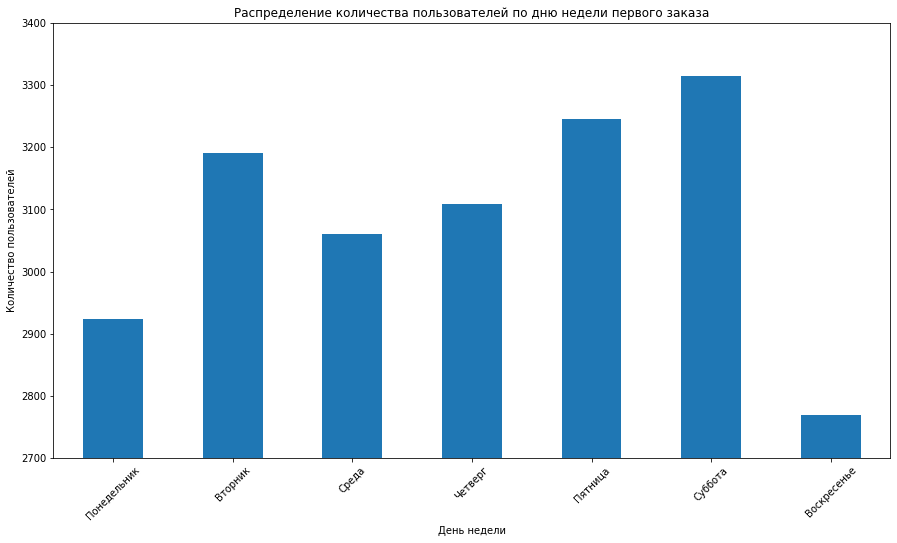

In [70]:
weekday_groups['user_count'].plot(kind='bar',
                    title = 'Распределение количества пользователей по дню недели первого заказа',
                    xlabel = 'День недели',
                    ylabel = 'Количество пользователей',
                    ylim = [2700, 3400],
                    rot = 45,
                    figsize=(15, 8))

new_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()

Чаще всего люди выбирают для первого заказа субботу (3300 пользователей), пятницу (3250 пользователей) и вторник (3200 пользователей). Это достаточно понятно и легко объяснимо - в пятницу и субботу у людей достаточно свободного времени (из-за сокращенного дня на работе, например, а суббота часто выделяется для встреч с друзьями и выполнения разных дел - для того, чтобы в субботу спокойно отдыхать), а во вторник спадает рабочий понедельничный ажиотаж и можно обсудить мероприятия с коллегами. По этим же причинам самое низкое количество первых заказов выпадает на понедельник (2900 пользователей) и воскресенье (2800 пользователей).

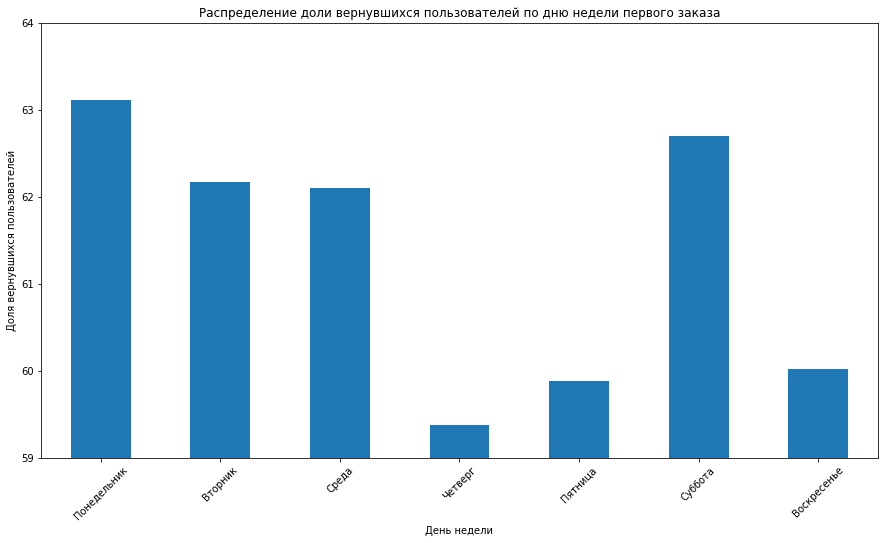

In [71]:
weekday_groups['is_two_mean'].plot(kind='bar',
                    title = 'Распределение доли вернувшихся пользователей по дню недели первого заказа',
                    xlabel = 'День недели',
                    ylabel = 'Доля вернувшихся пользователей',
                    ylim = [59, 64],
                    rot = 45,
                    figsize=(15, 8))

new_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(len(new_labels)), new_labels)
plt.show()

Распределение доли вернувшихся пользователей по дню первого заказа претерпело некоторые изменения относительно предыдущей метрики. Да, среди пользователей, совершивших заказы в субботу и вторник, доля вернувшихся пользователей велика (62.7% и 62.2% соответственно), а вот для пользователей, совершивших первый заказ в пятницу, доля вернувшихся невелика - всего 59.9%. Это может говорить о том, что первыйзаказ в пятницу пользовватели делают стихийно, на эмоциях, и повторно на сервис не возвращаются.

Также стоит отметить понедельник - для сравнительно небольшого количества пользователей, выбравших этот день для первого заказа, доля вернувшихся среди них наибольшая - 63.1%. Возможно, эти люди взяли себе за правило в начале недели заходитьт на портал и подыскивать себе возможность приятного проведения вечера или выходного.

---

**Задача 4.3.2.** Изучим средний интервал между заказами для вернувшихся пользователей. Для этого сгруппируем их по столбцам `is_two` и `is_five` и рассчитаем среднее время между заказами для каждой из групп:

In [72]:
activity_groups = profile[profile['is_two'] == 1].groupby('is_five')['avg_orders_interval'].mean()

display(activity_groups)

is_five
0    21.236226
1     9.982256
Name: avg_orders_interval, dtype: float64

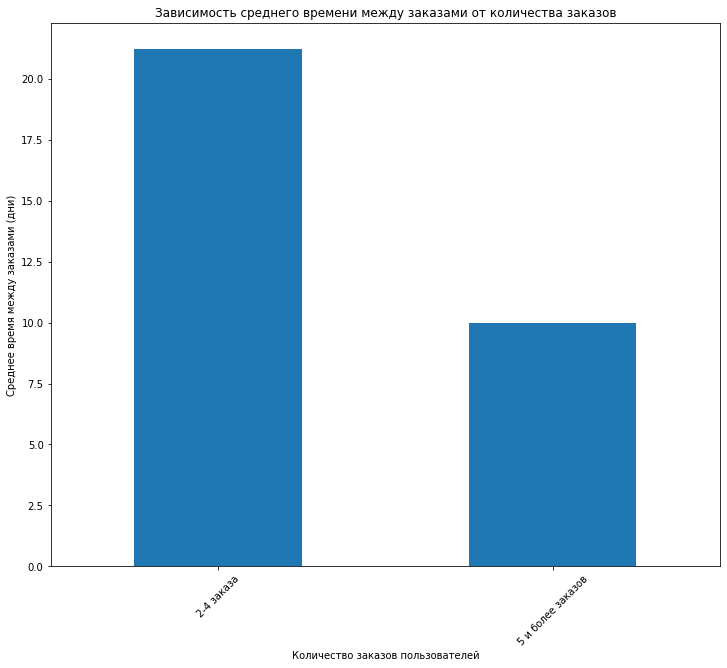

In [73]:
activity_groups.index = ['2-4 заказа', '5 и более заказов']

activity_groups.plot(kind = 'bar',
                     title = 'Зависимость среднего времени между заказами от количества заказов',
                     xlabel = 'Количество заказов пользователей',
                     ylabel = 'Среднее время между заказами (дни)',
                     rot=45,
                     figsize=(12, 10))

plt.show()

Согласно диаграмме, пользователи с бОльшим количеством заказов делают их (в среднем) в 2 раза чаще, т.к. средний интервал между заказами для пользователей с 5ю и более заказами составляет 10 дней против более чем 21 дня для пользователей с 2-4 заказами. Это говорит о том, что пользователи совершающие заказы чаще, совершают их больше, и наоборот - чем больше заказов совершают пользователи, тем чаще они это делают.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок посредством корреляционного анализа. Для этого построим матрицу корреляции столбца `total_orders` со столбцами `avg_revenue_rub`, `avg_tickets_count` и `avg_orders_interval` (т.к. связь данного столбца со столбцами `is_two` и `is_five` очевидна). При этом используем параметр `interval_cols` для определения интервальных данных:

,total_orders
total_orders,1.000000
avg_orders_interval,0.496591
avg_revenue_rub,0.405010
avg_tickets_count,0.319475


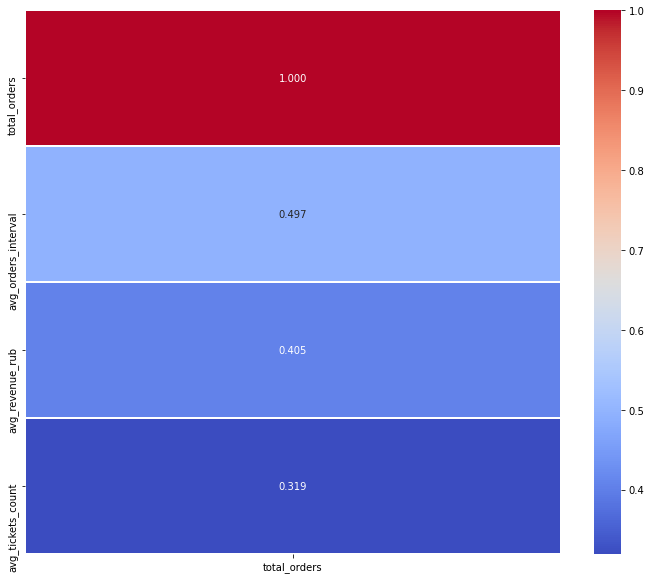

In [74]:
# Числовые и бинарные переменные
corr_col = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']

interval_cols = ['avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']


matrix = profile[corr_col].phik_matrix(interval_cols=interval_cols)['total_orders'].sort_values(ascending=False).to_frame()

display(matrix)

# Создание тепловой карты:
plt.figure(figsize=(12, 10))

sns.heatmap(data=matrix,
           annot=True,
           cmap='coolwarm',  # Добавляем цветовую схему
           fmt='.3f',         # Формат чисел (3 знака после запятой)
        linewidths=0.5)    # Линии между ячейками

plt.show()

Наилучшую корреляцию столбец total_orders показывает со столбцом avg_orders_interval - как мы выясняли, данные действительно зависят между собой (чем больше заказов в среднем у пользователя, тем меньше время между ними). Корреляция столбца total_orders с остальными также была исследована ранее, но согласно матрице, она менее выраженная, чем со столбцом avg_orders_interval.

Однако посмотрим, останутся ли данные такими же, если пользователи будут разделены по количеству заказов. Для этого углубим исследование, объединив данные в группы по столбцам `is_two` и `is_five` для кждой из категорий:

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable tickets_group for analysis 1. Dropping this column
  warnings.warn(


,1 заказ,2-4 заказа,5 заказов и более
total_orders,1.000000,1.000000,1.0000
avg_revenue_rub,0.244053,0.139338,0.0000
avg_tickets_count,0.172588,0.207931,0.0000
avg_orders_interval,NaN,0.398914,0.7993


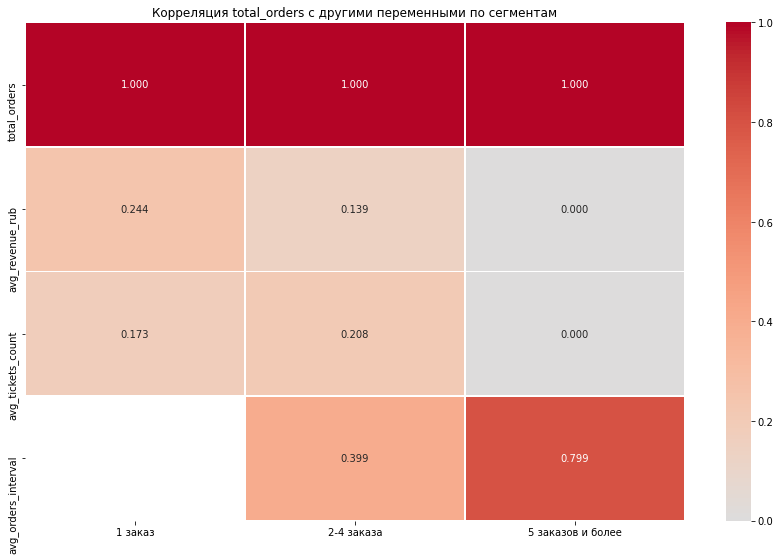

In [75]:
# Задаем граничные условия для группировки пользователей и названия групп:
bins = [1, 2, 5, float('inf')]
labels = ['1 заказ', '2-4 заказа', '5 заказов и более']

profile_copy = profile.copy()

# Создаем столбец с группами
profile_copy['tickets_group'] = pd.cut(profile['total_orders'], bins=bins, labels=labels, include_lowest=True)

# Числовые и бинарные переменные
corr_col_gr = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval', 'tickets_group']

interval_cols_gr = ['avg_revenue_rub', 'avg_tickets_count', 'avg_orders_interval']

# Создаем объединенную таблицу
combined_corr = pd.DataFrame()

# Строим отдельные матрицы для каждой категории и присоединяем их к объединенной матрице
for segment in labels:
    segment_data = profile_copy[profile_copy['tickets_group'] == segment]
    
    if len(segment_data) > 0:  # Проверяем, что в сегменте есть данные
        matrix_grouped = segment_data[corr_col_gr].phik_matrix(interval_cols=interval_cols_gr)
        matrix_grouped = matrix_grouped['total_orders'].sort_values(ascending=False).to_frame()
        matrix_grouped.columns = [segment]
        combined_corr = pd.concat([combined_corr, matrix_grouped], axis=1)
        
display(combined_corr)

# Визуализация объединенной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(data=combined_corr,
           annot=True,
           cmap='coolwarm',
           fmt='.3f',
           linewidths=0.5,
           center=0)
plt.title('Корреляция total_orders с другими переменными по сегментам')
plt.tight_layout()
plt.show()

При укрупнении нашего исследования становится видна разница в матрицах корреляции без разделения на группы и с разделением. Например, столбец total_orders для пользователей с 1 заказом никак не коррелирует со столбцом avg_orders_interval (что очевидно, ведь для них этот столбец не заполнен), да и с остальными столбцами корреляция прослеживается достаточно слабая. Для пользователей с 5 и более заказами наоборот - столбец total_orders коррелирует ТОЛЬКО со столбцом avg_orders_interval, причем достаточно сильно. Столбец total_orders для пользователей с 2-4 заказами показывает корреляцию со всеми столбцами, однако более выражена корреляция со столбцом avg_orders_interval, а для остальных она более слабая.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В ходе разработки проекта были проделаны следующие операции:
1. Выгрузка данных из базы при помощи SQL-запроса и их анализ.
    Т.к. данные и так содержались в достаточно хорошем качестве (практически без пропусков и с корректным типом) их предобработка не потребовалась;
    
2. Предобработка данных:
    2.1. Определение явных дубликатов по столбцам user_id и order_ts: обнаружено и удалено 170 строк (0,06% от всего объема данных в датафрейме);
    2.2. Поиск неявных дубликатов по столбцам event_type_main, service_name, city_name и region_name - неявные дубликаты не были обнаружены;
    2.3. Приведение значений выручки к одной валюте - перевод тенге в рубли по датафрейму final_tickets_tenge_df.csv;
    2.4. Проверка данных на наличие отрицательной выручки с заказов - обнаружено и удалено 379 строк (0,13% от всего объема данных в датафрейме);
    2.5. Проверка столбца `revenue_rub` на наличие аномально больших значений - данные были отфильтрованы по 99му процентилю, в ходе чего было удалено 2824 строки (1% от всего объема данных в датафрейме);
    2.6. Проверка столбца `tickets_count` на наличие аномальных значений и выбросов - аномальных значений и выбросов в данном столбце не обнаружено;
    
    По итогам предобработки данных было удалено 3373 строк, что сотавило 1.16% всех строк исходного датафрейма.
3. Создание профиля пользователей по 13 параметрам и его последующий анализ:
    3.1. Определены пропуски в данных - пропуски содержатся только в столбце `avg_orders_interval` для пользователей, совершивших только 1 заказ;
    3.2. Выполнено распределение пользователей по категориям (1 заказ, 2-4 заказа и 5 и более заказов);
    3.3. Определена средняя выручка с одного заказа;
    3.4. Изучены столбцы `total_orders`, `avg_tickets_count` и `avg_orders_interval` на аномальные значения и выбросы - выбросы обнаружены только в столбце `total_orders` в количестве 218 штук (1% от всего объема данных датафрейма). Впоследствии эти данные были удалены;
    3.5. Уточнены описанные выше параметры для обновленного датафрейма.

4. Исследовательский анализ датафрейма с профилями пользователей:
    4.1. Проведено исследование признаков первого заказа и их связи с возвращением на платформу:
    - После группировки пользователей по столбцам `first_order_device`, `first_order_region`, `first_order_service` и `first_order_event` определено их количество и доля от общего количества в каждом сегменте. Для первого заказа пользователи чаще всего выбирали билеты на концерт, который проходил в Каменевский регион, Североярская область или Широковская область, билет на который чаще всего покупали с мобильного девайса через операторов  "Билеты без проблем", "Мой билет", "Лови билет!", "Билеты в руки" и "Облачко".
    - Для каждого сегмента определена доля пользователей, совершивших два и более заказов. При распределении пользователей по категориям чаще возвращаются те, кто в первый раз выбрал билет на концерт, в театр или на выставку, а при распределении по типу устройства, выбранного для первого заказа - те, кто сделал заказ с ПК. Среди лидеров по доле вернувшихся пользователей в разрезе региона первого мероприятия числятся Шанырский регион, Светополянский округ и Широковская область, а в разрезе билетного оператора - "Край билетов", "Дом культуры", "Весь в билетах", "Прачечная" и "Билеты в руки"
    4.2. Выполнено исследование поведения пользователей через показатели выручки и состава заказа
    - Оценено распределение средней выручки с заказов для 2х групп пользователей: совершивших 1 заказ и совершивших более 1 заказа. Для тех, кто совершил только один заказ, характерно большое количество пользователей, принесших сервису малую выручку (около 100 рублей), а характер изменения количества пользователей в зависимости от роста выручки оказался ниспадающим. Для вернувшихся пользователей распределение иное - они чаще всего приносят сервису около 600 рублей выручки с одного заказа, при этом распределение имеет ярко выраженный пик в этом месте. Также стоит отметить, что в области больших значений выручки (более 800 рублей с заказа) количество клиентов, которые воспользовались сервисом единожды, на каждом интервале превышает количество вернувшихся пользователей;
    - Предыдущее исследование было углублено для вернувшихся пользователей: аналогичное исследование проведено для групп "пользователи, совершившие 2-4 заказа" и "пользователи, совершившие 5 и более заказов". Для первой группы пользователей наиболее характерны небольшие значения средней выручки - распределение средней выручки с заказа не имеет ярко выраженного пика и имеет плато в диапазонах средней выручки от 200 до 500 рублей. А вот для второй категории наблюдается тот самый пик в области выручки 500-600 рублей с клиента, а само значение выручки как стремительно растет в начале, так и стремительно убывает в конце. Причем так же, как и в прошлом исследовании, стоит отметить, что среди пользователей, совершивших меньшее количество заказов, больше доля тех, кто принес порталу большие выручки, чем среди тех пользователей, кто совершил больше заказов (для значений средней выручки более 800 рублей с пользователя в каждом интервале доля пользователей с 2-4 заказами больше, чем доля пользователей с 5 и более заказами);
    - Произведен анализ влияния среднего количества билетов в заказе на вероятность повторной покупки. Наибольшая доля вернувшихся пользователей наблюдается в сегменте "от 2х до 3х билетов" за раз и "от 3 до 5 билетов" - 74% и 63.5% соответственно. Среди остальных пользователей доля вернувшихся невелика - 40% для пользователей с 1-2 заказами в среднем и 32% для пользователей с более чем 5 заказами.
    4.3. Исследованы временные характеристики первого заказа и их влияния на повторные покупки:
    - Проанализировано влияние дня недели, в которой была совершена первая покупка, на поведение пользователей - чаще всего люди выбирают для первого заказа субботу, пятницу и вторник. При этом доля вернувшихся пользователей велика среди тех, кто совершил первый заказ не только в субботу и вторник, но и в понедельник (для него доля вернувшихся среди них наибольшая);
    - Изучен средний интервал времени между заказами вернувшихся пользователей - пользователи с бОльшим количеством заказов делают их (в среднем) в 2 раза чаще, Это говорит о том, что пользователи совершающие заказы чаще, совершают их больше, и наоборот - чем больше заказов совершают пользователи, тем чаще они это делают.
    4.4. Произведен корреляционный анализ столбца `total_orders` со столбцами `avg_revenue_rub`, `avg_tickets_count` и `avg_orders_interval` как для датафрейма в целом, так и при разбиении его на группы по количеству заказов. Столбец total_orders для пользователей с 1 заказом слабо коррелирует с остальными столбцами. Для пользователей с 5 и более заказами наоборот - столбец total_orders коррелирует ТОЛЬКО со столбцом avg_orders_interval, причем достаточно сильно. Столбец total_orders для пользователей с 2-4 заказами показывает корреляцию со всеми столбцами, однако более выражена корреляция со столбцом avg_orders_interval, а для остальных она более слабая.

После исследования стоит отметить несколько характеристик в профиле пользователей, на которые стоит обратить внимание для его удержания на портале:
1. Категория мероприятий. Такие популярные виды активностей, как спортивные мероприятия и стендап, не привлекают особо большого количества пользователей и даже после заказа билетов на них клиенты редко возвращаются. Возможно, стоит проработать меры привлечения клиентов на них При этом также не стоит сдвигать фокус с театров и концертов - их стабильно часто посещают и после их посещения часто возвращаются на сервис. Возможно, стоит разработать какие-то варианты поддержки таких пользователей, чтобы большая доля оставалась на портале;
2. Тип девайса. Количество заказов с ПК невелико, но доля оставшихся пользователей для них солидная - возможно, десктопная версия сайта не так удобна, как приложение для заказа с телефона. Также стоит поработать над возвращением пользователей мобильных устройств - они не так часто возвращаются. Стоит проработать варианты напоминаний/уведомлений о новых ивентах;
3. Даты заказов. Возможно, стоит перенастроить отправку уведомлений о новых ивентах на начало выходных и понедельник/вторник - статистически в такие дни чаще всего делаются заказы и доля вернувшихся пользователей в такие дни велика.
4. Периодичность напоминаний - для того, чтобы не терять клиентов, но и не надоедать оставшимся, можно рассылать уведомления раз в 10 дней - именно таков средний период между заказами пользователей для тех, кто сделал их не очень много. Это также может позволить сократить время между заказами для тех пользователей, кто остался на портале надолго.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

In [78]:
from jupyter_core.paths import jupyter_config_dir, jupyter_data_dir
print("Config dir:", jupyter_config_dir())
print("Data dir:", jupyter_data_dir())

Config dir: /home/jovyan/.jupyter
Data dir: /home/jovyan/.local/share/jupyter


**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**